In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gpflow
import tensorflow.compat.v1 as tf
from sklearn.metrics import r2_score,mean_absolute_error
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import ParameterGrid
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns

tf.disable_v2_behavior()
tf.compat.v1.disable_eager_execution()

#models
#---------------------------------------------------------------
#---------------------------------------------------------------
def moving_average(data, window_size, n_forecast):
    return data.rolling(window = window_size).mean().iloc[-n_forecast:]

#---------------------------------------------------------------
def autoregression(data, start, end):
    res = AutoReg(data, lags = 1).fit()
    return res.model.predict(res.params, start = start, end = end)

#---------------------------------------------------------------
def simple_exponential_smoothing(data, n_forecast):
    model = SimpleExpSmoothing(data)
    model_fit = model.fit()
    return model_fit.forecast(n_forecast)

#---------------------------------------------------------------
def holtWinter_smoothing(data, n_forecast):
    model = ExponentialSmoothing(data)
    model_fit = model.fit()
    return model_fit.forecast(n_forecast)

#---------------------------------------------------------------
def arima_model(data, n_forecast):
    model = ARIMA(endog = data)
    model_fit = model.fit()
    return model_fit.forecast(steps = n_forecast)

#---------------------------------------------------------------
def linear_regression_model(Xtrain, ytrain, Xtest):
    
    model = LinearRegression()
    model.fit(Xtrain, ytrain)
    return model.predict(Xtest)

#---------------------------------------------------------------
def GPR(Xtrain, ytrain, Xtest):


    kernel = gpflow.kernels.RBF(lengthscales = 10)

    model = gpflow.models.SGPR(data = (Xtrain, ytrain), 
                               kernel = kernel, 
                               inducing_variable = Xtrain[::10])

    #opt = gpflow.optimizers.Scipy()
    opt = tf.optimizers.Adam()
    opt_logs = opt.minimize(model.training_loss, 
                            model.trainable_variables, 
                            options = dict(maxiter = 100))
    predictions, _ = model.predict_y(Xtest)
    return predictions

#---------------------------------------------------------------


In [29]:

df = pd.read_csv("52.75_Vandstand_Minut.csv", 
                        delimiter = ";", 
                        skiprows = 12,
                        encoding = "unicode-escape")

df=df.drop(columns=['ks mrk.'])
df=df.rename(columns={"Dato (DK normaltid)":"time", "Vandstand (m DVR90)":"level"})
df['time'] = pd.to_datetime(df['time'], format='%d-%m-%Y %H:%M')

df.set_index('time', inplace=True)
df.head()

,level
time,
2014-06-20 00:00:00,11.421
2014-06-20 00:15:00,11.421
2014-06-20 00:30:00,11.422
2014-06-20 00:45:00,11.422
2014-06-20 01:00:00,11.422


<Axes: title={'center': 'Water level Sengeløse '}, xlabel='time'>

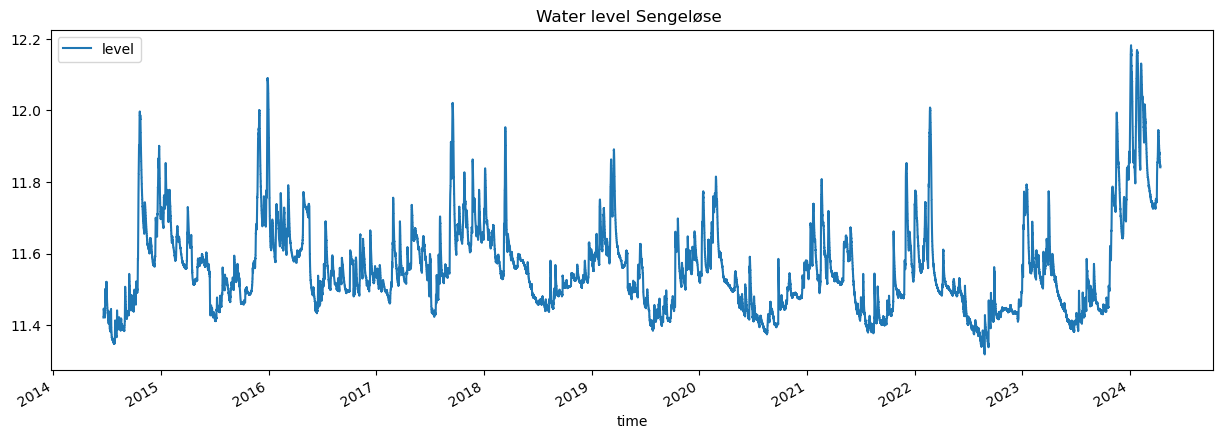

In [30]:
df.plot( figsize=(15, 5), title="Water level Sengeløse ")

In [31]:
#feature creation ideas

def create_features(df):
    
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['quarter'] = df.index.quarter
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week 
    return df

df = create_features(df)
#df['time_numeric'] = (df.index - df.index.min()) / pd.Timedelta(minutes=15)


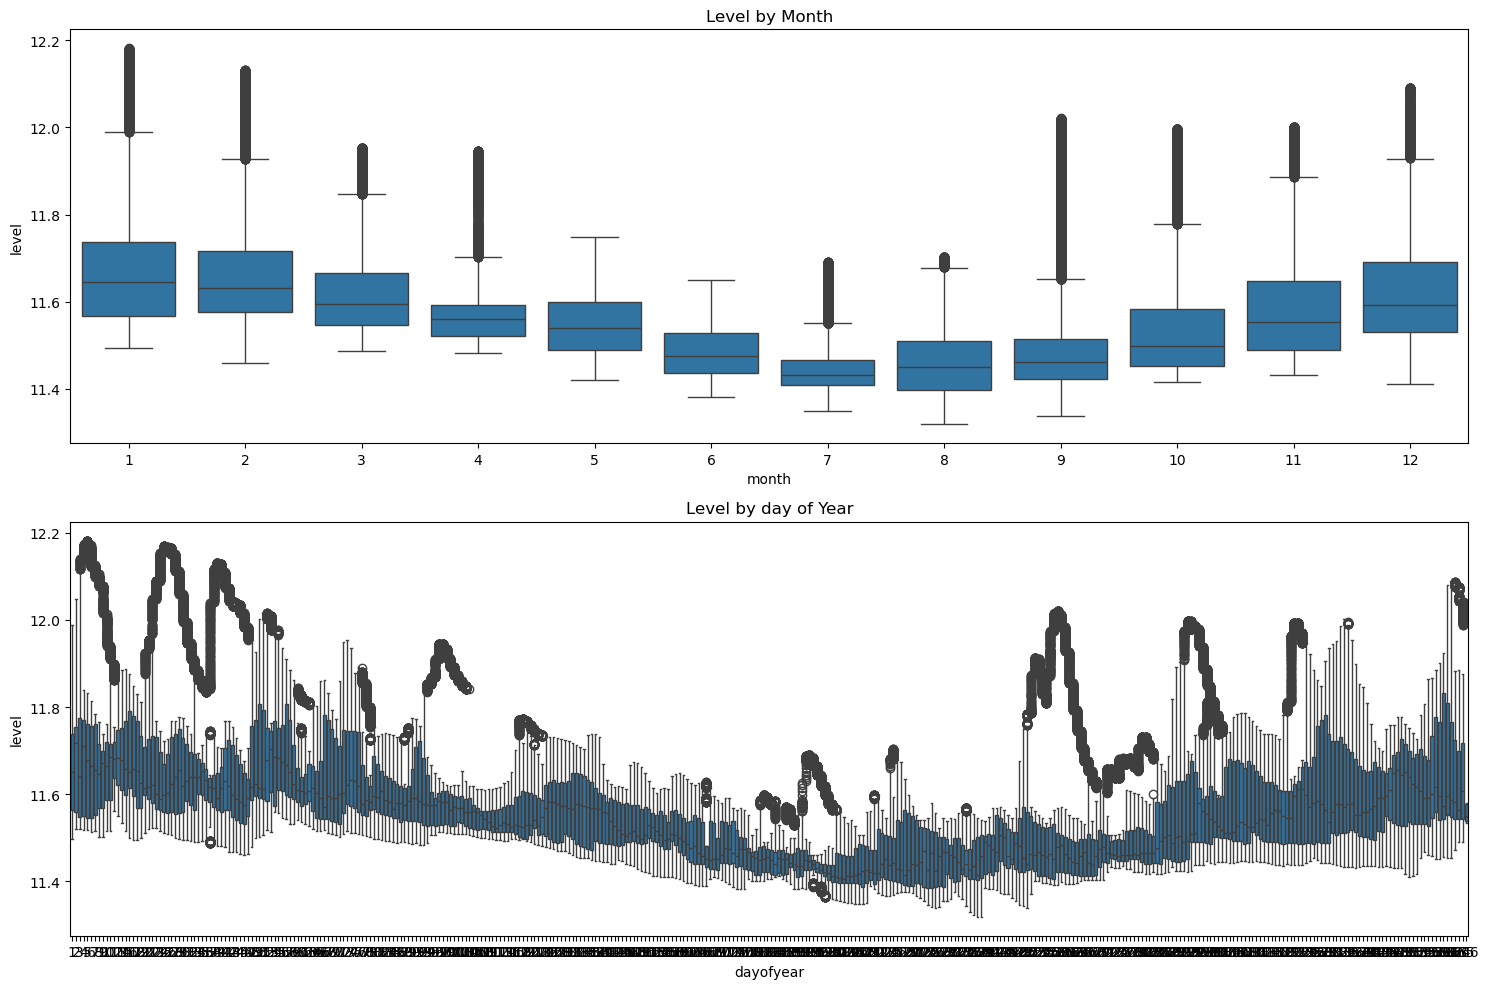

In [32]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

sns.boxplot(data=df, x='month', y='level', ax=axs[0])
axs[0].set_title('Level by Month')

sns.boxplot(data=df, x='dayofyear', y='level', ax=axs[1])
axs[1].set_title('Level by day of Year')

plt.tight_layout()
plt.show()

In [33]:
# lag creation 

def add_lags(df):
    target_map = df['level'].to_dict()

    # Add hourly lags
    #for hours in [1, 4, 8, 16, 24]:
    #    df[f'lag_{hours}h'] = (df.index - pd.Timedelta(hours, unit='h')).map(target_map)

    # Add daily lags for the last 7 .. 31days
    for days in range(7, 7):
        df[f'lag_{days}d'] = (df.index - pd.Timedelta(days, unit='d')).map(target_map)
    df=df.bfill()

    return df

df = add_lags(df)


In [34]:
#split function 

def split(n_splits=10,test_size=4 * 24 * 7, df=df):
    total_length = len(df)
    interval_length = (total_length // n_splits) - test_size

    for i in range(n_splits):
        end_train = i * (interval_length + test_size) + interval_length
        start_test = end_train
        end_test = start_test + test_size

        if end_test > total_length:  # Ensure the test data is within bounds
            break

        train_idx = np.arange(0, end_train)
        test_idx = np.arange(start_test, end_test)

        yield train_idx, test_idx
    

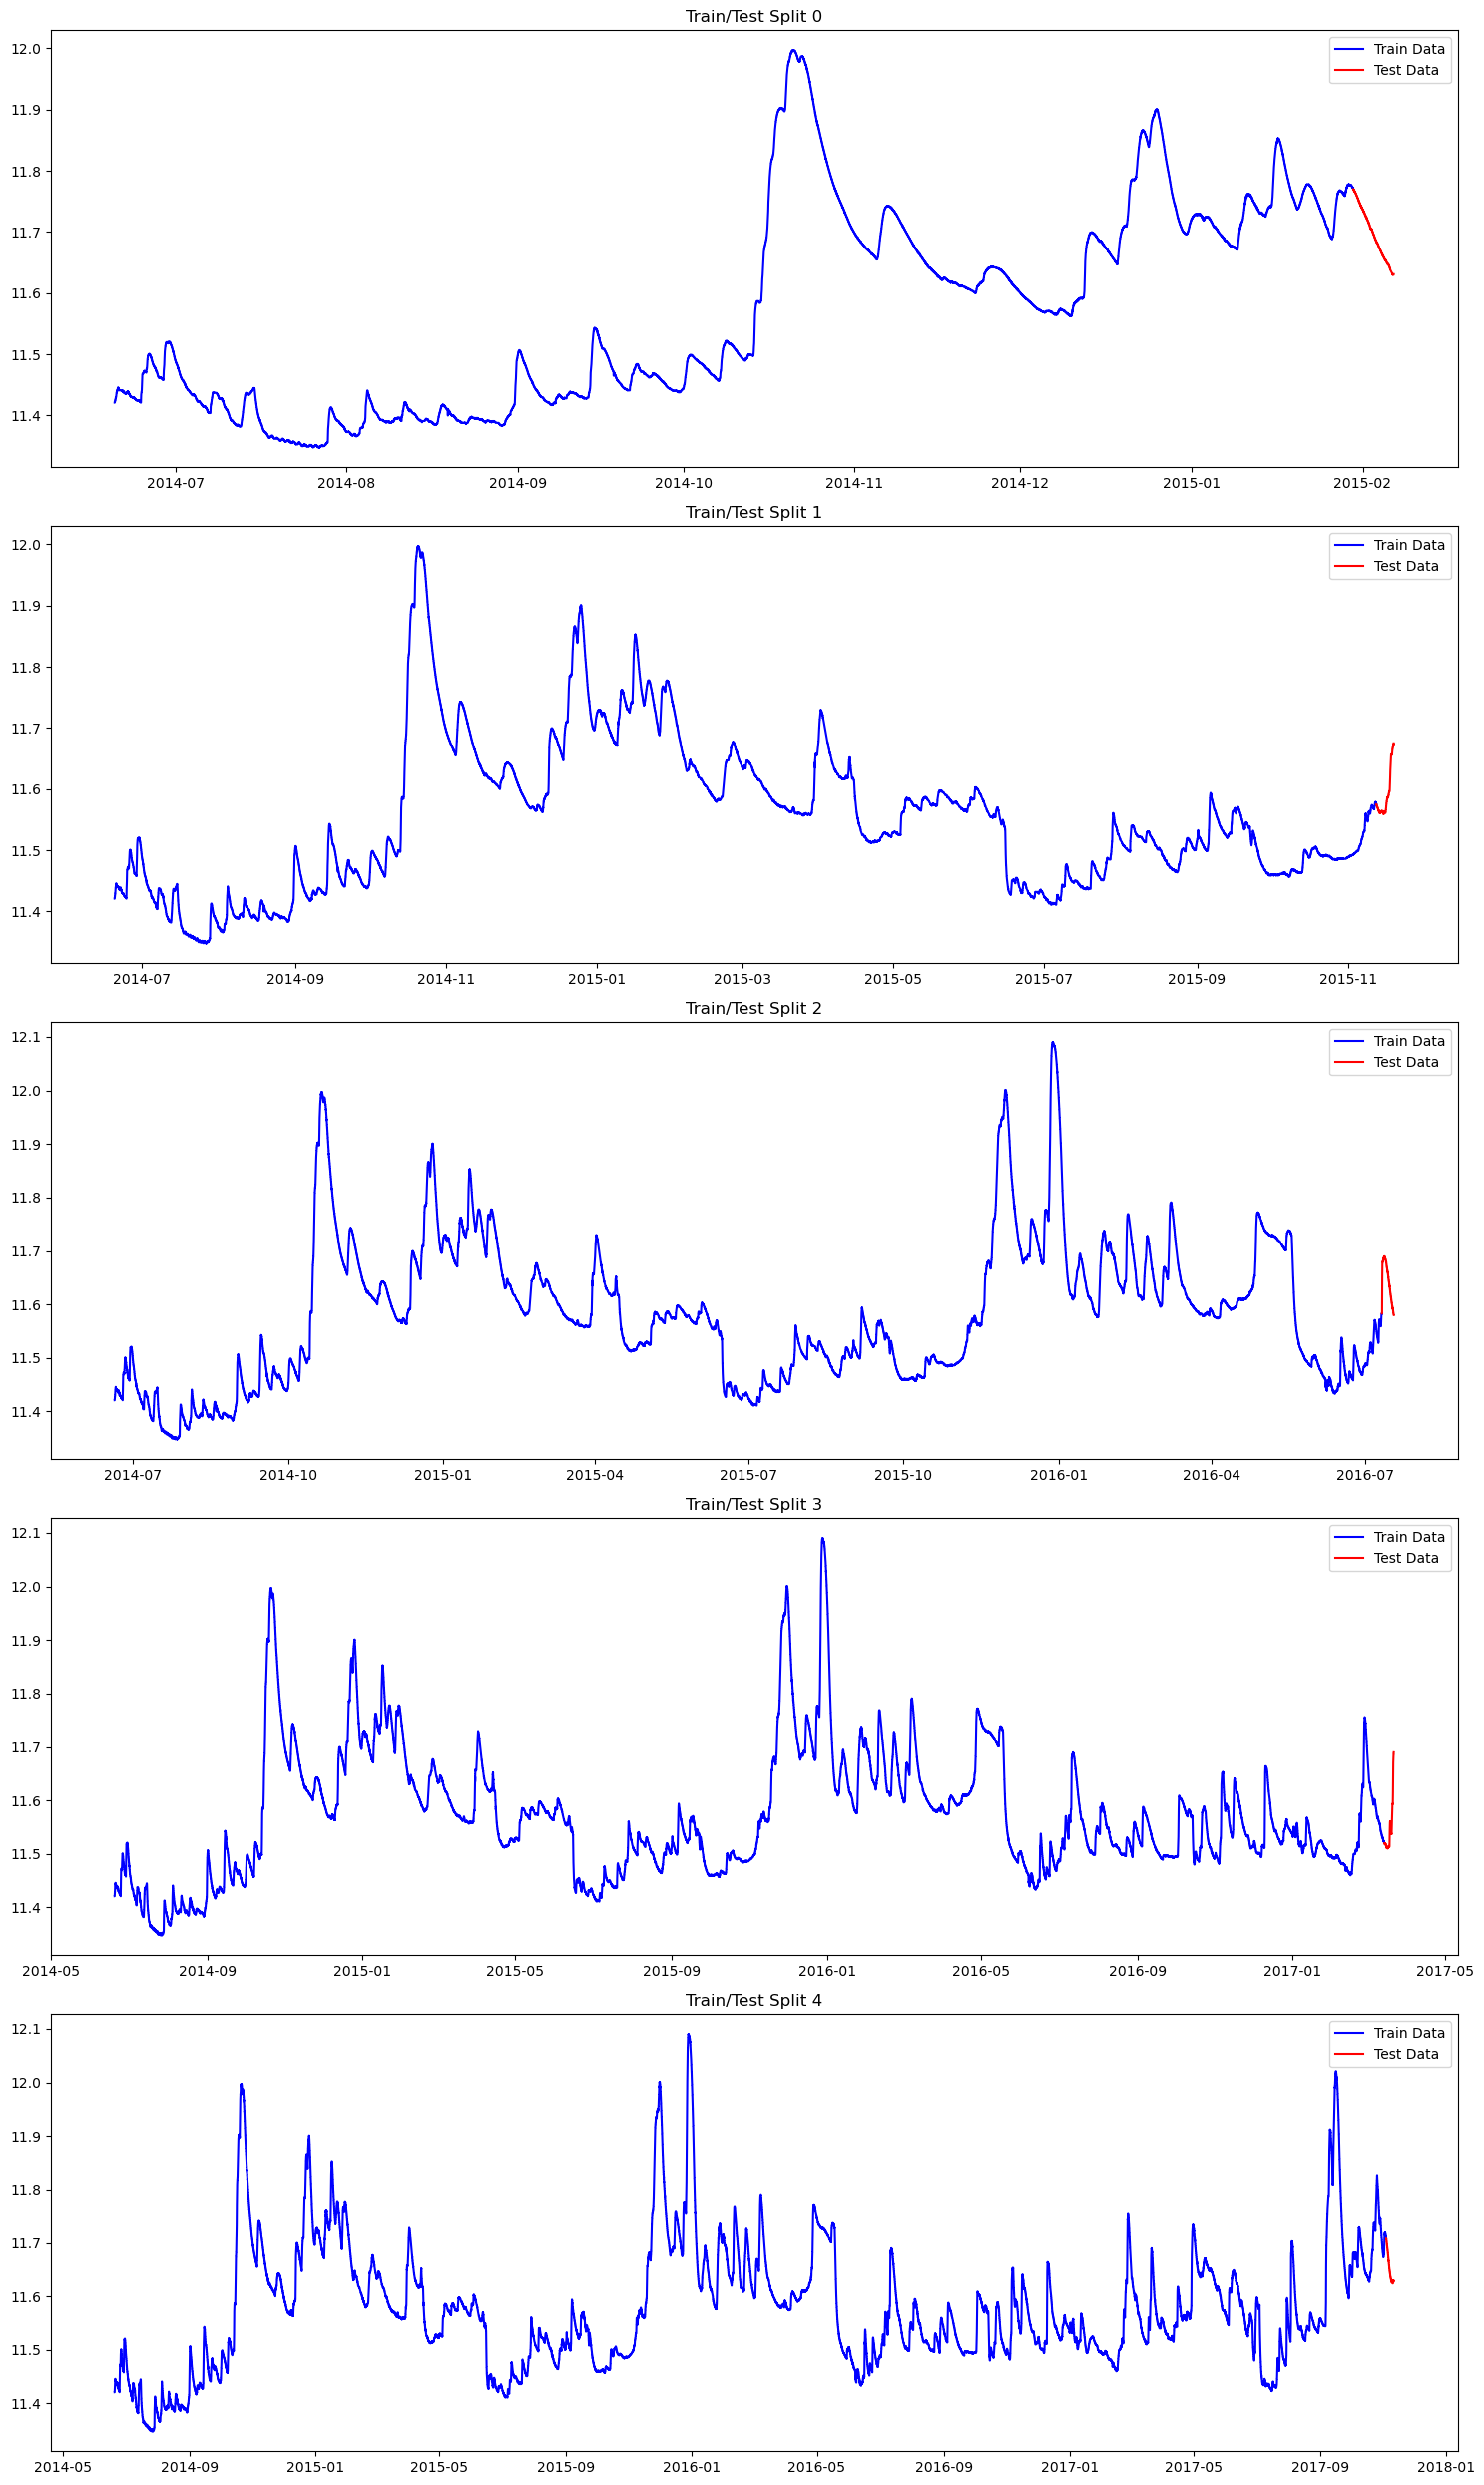

In [35]:

n_splits = 15  # Total intended splits, not directly used for plotting
test_size = 4 * 24 * 7
display_splits = 5  # Number of splits to display

# Plotting
fig, axs = plt.subplots(display_splits, 1, figsize=(15, 5 * display_splits))  #

count = 0
for train_idx, test_idx in split(n_splits):  
    if count >= display_splits:  
        break

    train = df.iloc[train_idx]
    test = df.iloc[test_idx]

    # Plot on the corresponding subplot axis
    axs[count].plot(train.index, train["level"], label='Train Data', color='blue')
    axs[count].plot(test.index, test["level"], label='Test Data', color='red')
    axs[count].set_title(f"Train/Test Split {count}")
    axs[count].legend()

    count += 1  # Increment to move to the next subplot

plt.tight_layout()  # Adjust layout to make sure labels and titles don't overlap
plt.show()

In [36]:
def runxgb(model, df, features=df.columns):
    r2_scores = []
    predictions_list = []
    i=0
    for train_idx, test_idx in split(10):
        i+=1
        if 'level' in features:  # Check if 'level' is among the features and not alone
            X_train = df.iloc[train_idx][features].drop(columns=['level'])
        else:
            X_train = df.iloc[train_idx][features]
        y_train = df.iloc[train_idx]['level']

        if 'level' in features:  # Repeat the check for the test set
            X_test = df.iloc[test_idx][features].drop(columns=['level'])
        else:
            X_test = df.iloc[test_idx][features]
        y_test = df.iloc[test_idx]['level']
        
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)
        predictions = model.predict(X_test)
       
        r2 = mean_absolute_error(y_test, predictions)
        r2_scores.append(r2)
        predictions_list.append(predictions)
        # if i==9:
        #     print("pred",predictions)
        #     print("y_test",y_test.values)
        #     print(r2)
        #     p=predictions
        #     y=y_test.values
    
    
    
    return predictions_list, r2_scores

In [37]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")
warnings.filterwarnings("ignore", category=FutureWarning, module="statsmodels")

In [38]:
best_params= {
    'max_depth': 5,
    'min_child_weight': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'n_estimators': 500
}

In [39]:
print(df.columns)

Index(['level', 'hour', 'dayofweek', 'month', 'year', 'dayofyear', 'quarter',
       'dayofmonth', 'weekofyear'],
      dtype='object')


In [40]:

selected_features = []
remaining_features = df.columns.tolist()
best_score = float('inf')

while remaining_features:
    scores = {}
    for feature in remaining_features:
        if feature=="level":
            continue
        current_features = selected_features + [feature]
        model = xgb.XGBRegressor(**best_params, objective='reg:absoluteerror', early_stopping_rounds=50)
        _, r2 = runxgb(model, df, current_features)
        meanscore=np.mean(r2)
        scores[feature] = meanscore
        print(f"Tested {feature}: Mean R² = {meanscore}")

    best_feature, best_feature_score = min(scores.items(), key=lambda x: x[1])
    if best_feature_score < best_score:
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        best_score = best_feature_score
        print(f"Selected {best_feature} with improvement to R² = {best_feature_score}")
    else:
        print("No further improvement, stopping selection.")
        break
df = df[selected_features + ['level'] ]  # Ensuring 'level' is added back for use as the target variable
print("Selected features:", selected_features)


Tested hour: Mean R² = 0.1079826690242404
Tested dayofweek: Mean R² = 0.10789982594876064
Tested month: Mean R² = 0.06595540486403877
Tested year: Mean R² = 0.07152637164252144
Tested dayofyear: Mean R² = 0.06555498892352699
Tested quarter: Mean R² = 0.07641994863010589
Tested dayofmonth: Mean R² = 0.10677766177313668
Tested weekofyear: Mean R² = 0.06542511229855677
Selected weekofyear with improvement to R² = 0.06542511229855677
Tested hour: Mean R² = 0.06559115242731006
Tested dayofweek: Mean R² = 0.06566924389203392
Tested month: Mean R² = 0.06526913208734425
Tested year: Mean R² = 0.035228302039418916
Tested dayofyear: Mean R² = 0.06600264952523369
Tested quarter: Mean R² = 0.06479114753405257
Tested dayofmonth: Mean R² = 0.06634507874647778
Selected year with improvement to R² = 0.035228302039418916
Tested hour: Mean R² = 0.04313291691711972
Tested dayofweek: Mean R² = 0.044896045649619354
Tested month: Mean R² = 0.03934758329618549
Tested dayofyear: Mean R² = 0.03940176721073333


In [41]:

# Setup parameter grids
group1_params = {
    'max_depth': [ 5, 7, 9, 11],
    'min_child_weight': [ 3, 5, 7, 9]
}
group2_params = {
    'subsample': [0.6, 0.8, 1.0, ],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
group3_params = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 500, 1000, 2000]
}
# Default parameters, updated based on tuning

def tune_parameters(params_grid, fixed_params, df):
    results = {}
    best_params = None
    best_score = float('inf')

    for params in ParameterGrid(params_grid):
        current_params = fixed_params.copy()
        current_params.update(params)
        model = xgb.XGBRegressor(**current_params, objective='reg:absoluteerror', early_stopping_rounds=50)
        
        # Use runxgb function to train and evaluate the model
        _, r2 = runxgb(model, df, df.columns)
        r2_score=np.mean(r2)
        
        results[str(params)] = r2_score
        if r2_score < best_score:
            best_score = r2_score
            best_params = params
    
    return best_params, best_score

# Define features and split function (assuming these are defined elsewhere in your code)
best_group1_params, best_group1_r2 = tune_parameters(group1_params, best_params, df)
best_params.update(best_group1_params)
print("Best Group 1 Params:", best_group1_params, "R²:", best_group1_r2)

best_group2_params, best_group2_r2 = tune_parameters(group2_params, best_params, df)
best_params.update(best_group2_params)
print("Best Group 2 Params:", best_group2_params, "R²:", best_group2_r2)

best_group3_params, best_group3_r2 = tune_parameters(group3_params, best_params, df)
best_params.update(best_group3_params)
print("Best Group 3 Params:", best_group3_params, "R²:", best_group3_r2)



Best Group 1 Params: {'max_depth': 7, 'min_child_weight': 3} R²: 0.03468734503132956
Best Group 2 Params: {'colsample_bytree': 0.6, 'subsample': 0.6} R²: 0.03467158080396198
Best Group 3 Params: {'learning_rate': 0.1, 'n_estimators': 500} R²: 0.03467158080396198


Best Group 1 Params: {'max_depth': 5, 'min_child_weight': 3} R²: -1.6368060212174034
Best Group 2 Params: {'colsample_bytree': 0.8, 'subsample': 0.6} R²: -1.5846983156952636
Best Group 3 Params: {'learning_rate': 0.01, 'n_estimators': 1000} R²: -1.1999629875565228


In [42]:


# Custom split function as provide
mavg_windows = [1,2, 10,100, 1000, 100000]  # Example window sizes
mavg_results = {window: [] for window in mavg_windows}

# Training and validation loop
for train_idx, test_idx in split(100):
    trainData, testData = df.iloc[train_idx], df.iloc[test_idx]
    X_train, X_test = trainData.drop('level', axis=1), testData.drop('level', axis=1)
    Y_train, Y_test = trainData['level'], testData['level']

    # Moving average tuning
    for window in mavg_windows:
        forecast = trainData['level'].rolling(window=window).mean().iloc[-len(testData):]
        if len(forecast.dropna()) == len(Y_test):
            mse = mean_absolute_error(Y_test, forecast.dropna())
            mavg_results[window].append(mse)  # Append mse to the list for each window
            print(f"Window: {window}, MSE: {mse}")

# Calculate mean MSE for each window size and find the best one
mavg_avg_results = {window: np.mean(scores) if scores else np.nan for window, scores in mavg_results.items()}
best_mavg_window = max(mavg_avg_results, key=mavg_avg_results.get)
print("Best Moving Average window size:", best_mavg_window)
print("Best Moving Average MSE:", mavg_avg_results[best_mavg_window])

Window: 1, MSE: 0.04514434523809515
Window: 2, MSE: 0.04516964285714277
Window: 10, MSE: 0.045374553571428486
Window: 100, MSE: 0.04783566964285709
Window: 1000, MSE: 0.06001321130952377
Window: 1, MSE: 0.009760416666666735
Window: 2, MSE: 0.009768601190476239
Window: 10, MSE: 0.009825446428571458
Window: 100, MSE: 0.009747410714285762
Window: 1000, MSE: 0.007274845238095177
Window: 1, MSE: 0.018663690476190306
Window: 2, MSE: 0.018631696428571244
Window: 10, MSE: 0.01838720238095222
Window: 100, MSE: 0.015678154761904727
Window: 1000, MSE: 0.019093296130952318
Window: 1, MSE: 0.16063839285714285
Window: 2, MSE: 0.16081845238095238
Window: 10, MSE: 0.16225848214285715
Window: 100, MSE: 0.17798092261904766
Window: 1000, MSE: 0.19570519196428565
Window: 1, MSE: 0.04207886904761895
Window: 2, MSE: 0.04212574404761893
Window: 10, MSE: 0.042497619047618965
Window: 100, MSE: 0.04648913690476179
Window: 1000, MSE: 0.05117587351190466
Window: 1, MSE: 0.03618898809523799
Window: 2, MSE: 0.03614

In [43]:
df.head()

,weekofyear,year,level
time,,,
2014-06-20 00:00:00,25,2014,11.421
2014-06-20 00:15:00,25,2014,11.421
2014-06-20 00:30:00,25,2014,11.422
2014-06-20 00:45:00,25,2014,11.422
2014-06-20 01:00:00,25,2014,11.422


In [45]:


results = {}
bestxgb = xgb.XGBRegressor(**best_params, objective='reg:absoluteerror', early_stopping_rounds=50)

predictions,r2=runxgb(bestxgb,df, df.columns)

results["xgb"]= {
    "forecast": predictions,
    "r2":r2
}    

    


In [ ]:
mean_absolute_error(y,p)

0.03608072335379464

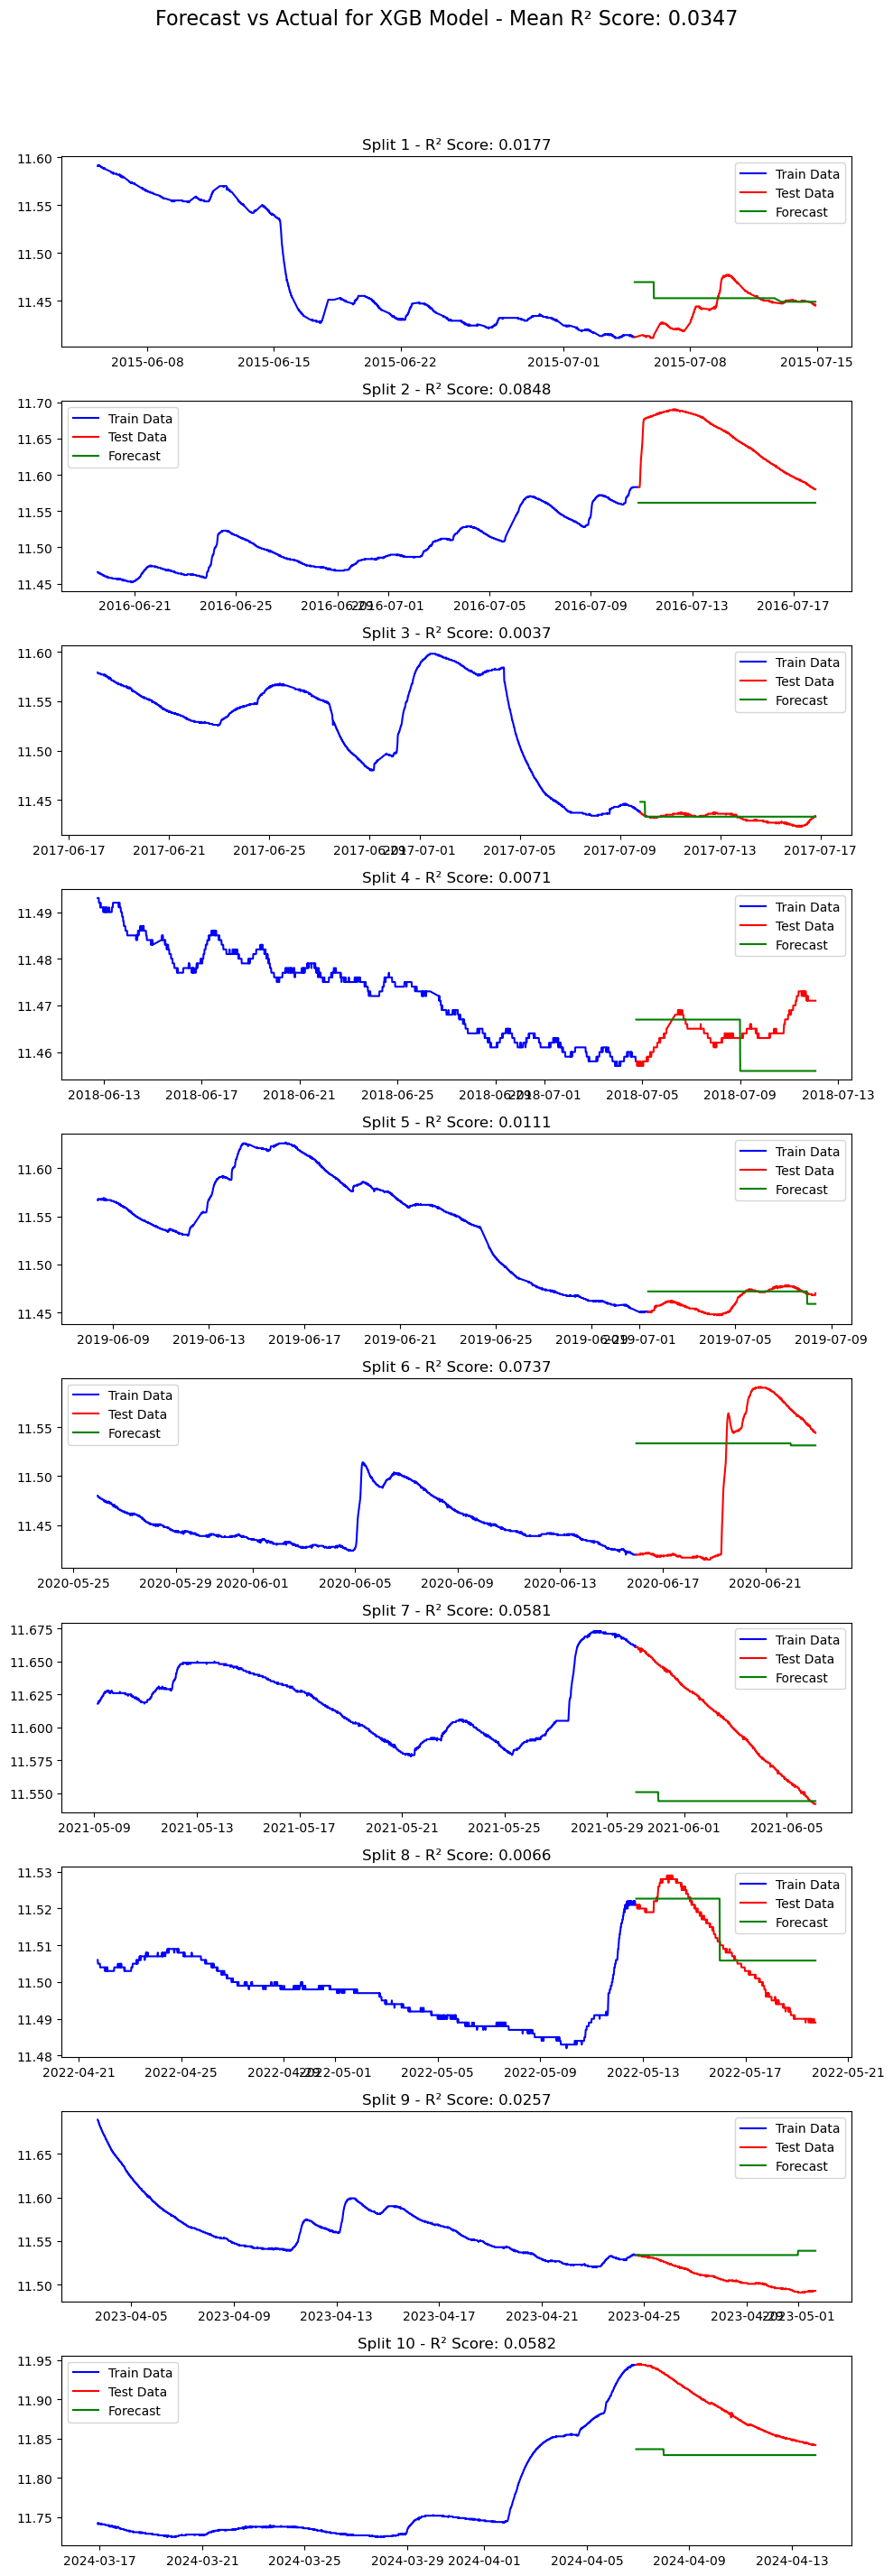

In [46]:
import matplotlib.pyplot as plt

# Calculate the mean R² score from the array of R² scores
mean_r2 = np.mean(results["xgb"]["r2"])

# Define the size of the test and training segments
test_size = 4 * 24 * 7  # For example, 4 days if data is in hours
train_display_size = test_size * 3  # Display three times the length of test_size from training data

# Create a figure with 10 subplots (one for each split), adjusting the size accordingly
fig, axs = plt.subplots(10, 1, figsize=(10, 30))
fig.suptitle(f'Forecast vs Actual for XGB Model - Mean R² Score: {mean_r2:.4f}', fontsize=16)

# Use the split function to get the correct indices
split_generator = split(n_splits=10, test_size=test_size, df=df)

for i, (train_idx, test_idx) in enumerate(split_generator):
    ax = axs[i]
    
    # Limit the training data to the last train_display_size elements before the test data starts
    train_end_idx = train_idx[-1]  # Last index of the training data
    train_start_idx = max(train_idx[0], train_end_idx - train_display_size + 1)  # Start index for the displayed training data

    # Slice the DataFrame for the last part of training data and for the test data
    train_data = df.iloc[train_start_idx:train_end_idx + 1]['level']
    test_data = df.iloc[test_idx]['level']

    # Plot the training data section
    ax.plot(train_data.index, train_data, label="Train Data", color="blue")
    # Plot the test data section
    ax.plot(test_data.index, test_data, label="Test Data", color="red")
    # Plot the corresponding predictions for the current split
    ax.plot(test_data.index, results["xgb"]["forecast"][i], label="Forecast", color="green")

    # Adding individual R² score for each split
    ax.set_title(f"Split {i+1} - R² Score: {results['xgb']['r2'][i]:.4f}")
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title
plt.show()